In [1]:
import numpy as np
import skimage as sk
import cv2
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
# LOAD VIDEO TO ARRAY

frames = []

cap = cv2.VideoCapture("0001-0800.mp4")
ret = True

while ret:
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        frames.append(img)
        
video = np.stack(frames, axis=0)
video.shape

(800, 720, 1280, 3)

In [3]:
frames[0].shape

(720, 1280, 3)

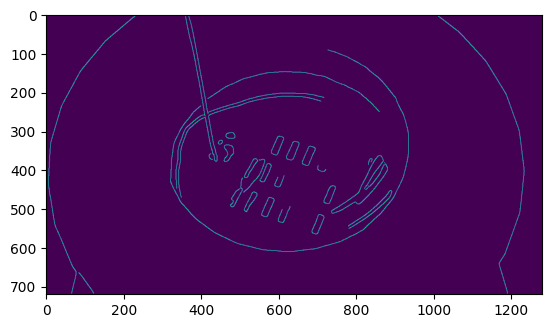

In [4]:
# EDGE DETECTOR

bw = sk.color.rgb2gray(frames[0])
p2, p98 = np.percentile(bw, (2, 98))
bw = sk.exposure.rescale_intensity(bw, in_range=(p2, p98))
edges = sk.feature.canny(bw, 3)
plt.imshow(edges)

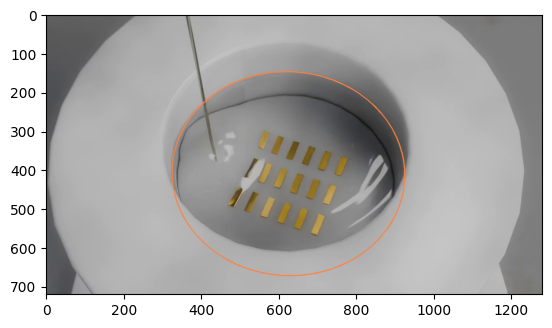

In [15]:
# FIND CONTOURS

binary = sk.util.img_as_ubyte(edges)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_image = np.copy(frames[0])

# width
w = frames[0].shape[1]

for contour in contours:
    # skip contours that are too small or too big
    if cv2.arcLength(contour, False) < 0.4 * w or cv2.arcLength(contour, False) > w:
        continue 
    ellipse = cv2.fitEllipse(contour)

    # ellipse[1] gives a pair of major and minor axis. Skip all ellipsoids with too narrow aspect ratio
    if ellipse[1][0] / ellipse[1][1] < 0.5:
        continue
    cv2.ellipse(contour_image, ellipse, (255, 128, 64), 2)
    break


plt.imshow(contour_image)

In [16]:
mask = np.zeros(frames[0].shape[:2], dtype=np.uint8)
cv2.ellipse(mask, ellipse, 255, -1)


mean = []

for f in frames:
    mean.append(cv2.mean(f, mask)[:3])

mean = np.array(mean)

In [17]:
mean_diff = []
for f in mean:
    mean_diff.append(cv2.subtract(f, mean[0]).reshape(4)[:3])

In [18]:
mean_diff = np.array(mean_diff)

In [19]:
mean_diff.shape

(800, 3)

(-10.0, 5.0)

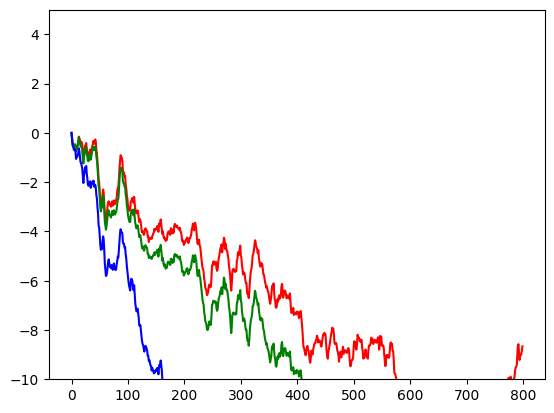

In [20]:
for i in range(3):
    plt.plot(mean_diff[:,i], color=["red", "green", "blue"][i])
plt.ylim(-10, 5)

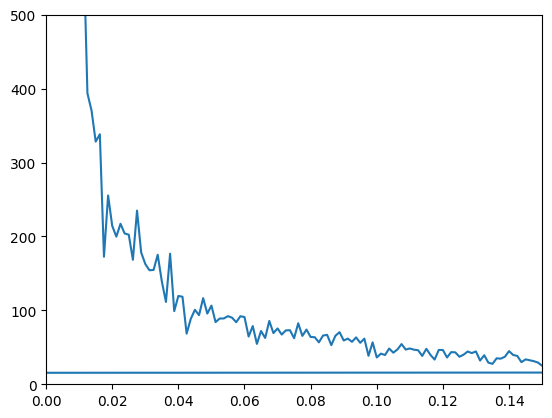

In [21]:
# FFT, probably irrelevant

yf = sp.fft.fft(mean_diff[:,2])
xf = sp.fft.fftfreq(len(frames))

plt.cla()
plt.plot(xf, np.abs(yf))
plt.xlim(0, 0.15)
plt.ylim(0, 500)
plt.show()

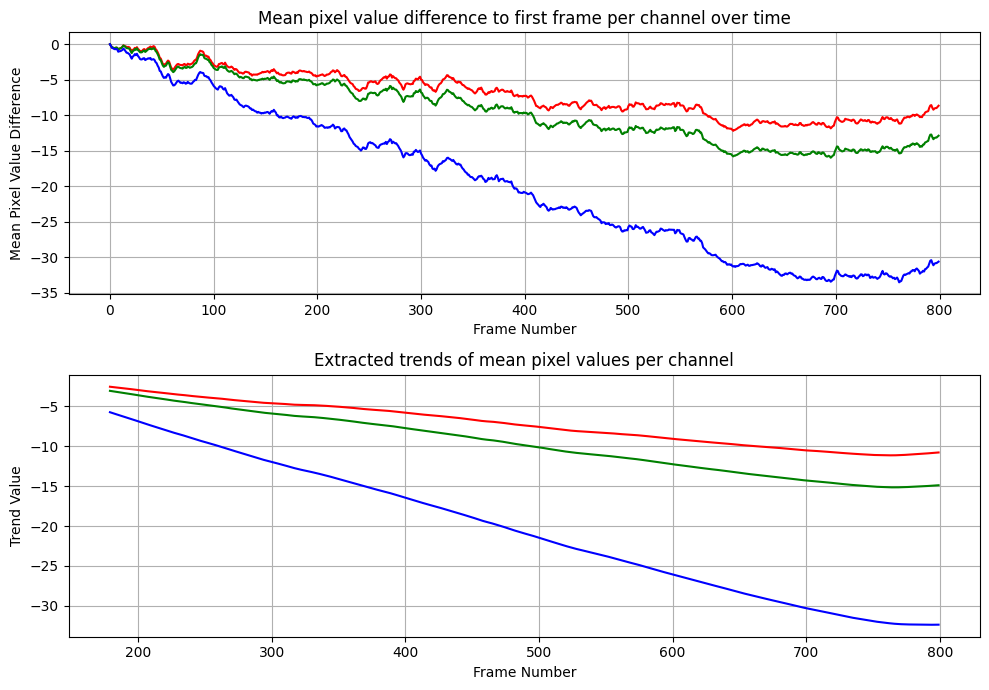

In [22]:

def extract_trend(signal, window_size):
    return np.convolve(signal, np.ones(window_size), 'valid') / window_size

def plot_diff(data, ax, colors):
    # Ensure data is 2D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    
    frame_count = data.shape[0]
    frame_nums = np.arange(frame_count)
    channel_count = data.shape[1]
    
    for i in range(channel_count):
        ax.plot(frame_nums, data[:, i], color=colors[i])
        
    ax.set_xlabel('Frame Number')
    ax.set_ylabel('Mean Pixel Value Difference')
    ax.set_title('Mean pixel value difference to first frame per channel over time')
    ax.grid(True)
    
def plot_trend(data, ax, colors, window_size, channel_name = "per channel"):
    # Ensure data is 2D
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
        
    frame_count = data.shape[0]
    frame_nums = np.arange(frame_count)
    channel_count = data.shape[1]
    trend_frame_nums = frame_nums[window_size-1:]
    trends = np.zeros((len(data) - window_size + 1, channel_count))
    
    for i in range(channel_count):
        trends[:, i] = extract_trend(data[:, i], window_size)
    
    for i in range(channel_count):
        ax.plot(trend_frame_nums, trends[:, i], color=colors[i])

    ax.set_xlabel('Frame Number')
    ax.set_ylabel('Trend Value')
    ax.set_title(f'Extracted trends of mean pixel values {channel_name}')
    ax.grid(True)

def plot_diff_and_trend(window_size, data, is_RGB = False):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    colors = ['red', 'green', 'blue'] if is_RGB else ['turquoise', 'darkorange', 'slategray']

    plot_diff(data, ax1, colors)
    plot_trend(data, ax2, colors, window_size)
    
    plt.tight_layout()
    plt.show()


plot_diff_and_trend(180, mean_diff, True)


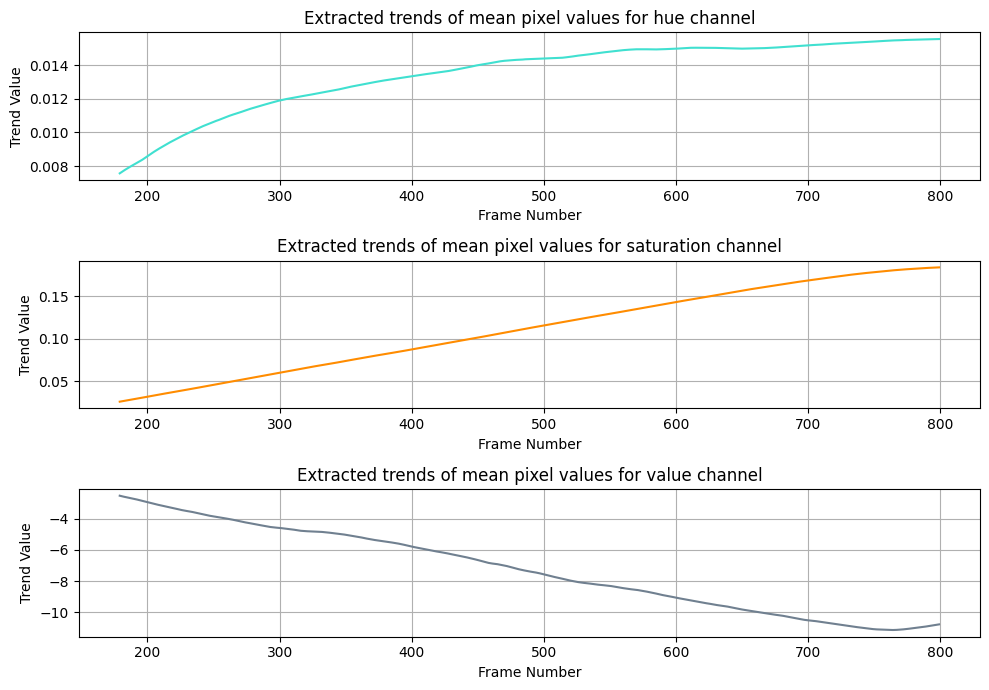

In [23]:
mean_hsv = sk.color.rgb2hsv(mean)
mean_hsv_diff = []
for f in mean_hsv:
    val = cv2.subtract(f, mean_hsv[0])
    mean_hsv_diff.append(val.reshape(4)[:3])

mean_hsv_diff = np.array(mean_hsv_diff)

# plot_diff_and_trend(180, frame_nums, mean_hsv_diff[:,0], False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7))
plot_trend(mean_hsv_diff[:,0], ax1, ["turquoise"], 180, "for hue channel")
plot_trend(mean_hsv_diff[:,1], ax2, ["darkorange"], 180, "for saturation channel")
plot_trend(mean_hsv_diff[:,2], ax3, ["slategray"], 180, "for value channel")

plt.tight_layout()
plt.show()


In [14]:
mean.shape[1]

3